In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

In [91]:
# Read in metadata and feature matrix
# Change to your own paths; feature_mat should have patient_id as rows and features as columns
metadata = pd.read_csv("~/Desktop/BNFO285_Projects/Data/processed/processed_metadata.txt", sep="\t", header=0)
metadata = metadata[metadata["hpv_status"] != "positive"]
metadata = metadata[metadata["tumor_site"] != "tonsil"]
res_dir = "/Users/clairez/Desktop/"
feature_tab = pd.read_csv("/Users/clairez/Desktop/BNFO285_Projects/Data/processed/filtered_cnv_status.tsv",
                          sep="\t", header=0, index_col=0)
feature_mat = feature_tab.T.copy()
feature_mat.index.name = "patient_id"
feature_mat

gene_name,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-CN-A642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-UF-A7JH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-UF-A7JO,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0
TCGA-CV-7180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0
TCGA-CV-6942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BB-A6UO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CR-6480,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
TCGA-DQ-5629,0.0,0.0,1.0,1.0,-1.0,0.0,0.0,0.0,-1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0


In [92]:
freq = feature_mat.mean(axis=0).sort_values(ascending=True)
freq
keep = freq[(freq >= 0.1) & (freq <= 0.9)].index
feature_mat = feature_mat[keep]
feature_mat

gene_name,LCN8,FOXE1,LHFPL3,MTERF1,RELN,PPP3R2,CTSV,LCE5A,TRMO,ZNF189,...,PEX5L,DNAJC19,SOX2,TTC14,CCDC39,FXR1,DCUN1D1,MCCC1,LAMP3,ATP11B
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-CN-A642,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-UF-A7JH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-UF-A7JO,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
TCGA-CV-7180,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CV-6942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BB-A6UO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CR-6480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
TCGA-DQ-5629,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [93]:
features = feature_mat.columns.tolist()

df = pd.merge(metadata, feature_mat, on="patient_id")
df = pd.get_dummies(df, columns=['gender'], drop_first=True)
df

,patient_id,age,OS,OS_time,DSS,DSS_time,DFI,DFI_time,tumor_site,tumor_class,...,DNAJC19,SOX2,TTC14,CCDC39,FXR1,DCUN1D1,MCCC1,LAMP3,ATP11B,gender_MALE
0,TCGA-4P-AA8J,66.0,0.0,102.0,0.0,102.0,NaN,NaN,tongue,primary,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
1,TCGA-BA-4074,69.0,1.0,462.0,1.0,462.0,NaN,NaN,tongue,primary,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,TCGA-BA-4075,49.0,1.0,283.0,1.0,283.0,NaN,NaN,tongue,primary,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,True
3,TCGA-BA-4076,39.0,1.0,415.0,1.0,415.0,NaN,NaN,Larynx,primary,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,True
4,TCGA-BA-4077,45.0,1.0,1134.0,1.0,1134.0,NaN,NaN,tongue,primary,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,TCGA-UF-A7JT,72.0,1.0,993.0,1.0,993.0,NaN,NaN,mouth,metastasis,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,False
442,TCGA-UF-A7JV,62.0,1.0,90.0,1.0,90.0,NaN,NaN,Hypopharynx,recurrence,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
443,TCGA-UP-A6WW,58.0,0.0,518.0,0.0,518.0,NaN,NaN,tongue,primary,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
444,TCGA-WA-A7GZ,58.0,1.0,625.0,0.0,625.0,0.0,625.0,mouth,primary,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,True


In [95]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

cutoff = 5 * 365  # 5 years in days
km_results = []

for gene in features:
    try:
        df_gene = df[["OS_time", "OS", gene]].copy()
        df_gene[gene] = df_gene[gene].astype(str)

        result = multivariate_logrank_test(df_gene['OS_time'], df_gene[gene], event_observed=df_gene['OS'])
        km_results.append((gene, result.p_value))

    except Exception as e:
        print(f"Skipping {gene}: {e}")

km_df = pd.DataFrame(km_results, columns=["gene", "p"])
km_df = km_df.sort_values("p")

km_df["q"] = multipletests(km_df["p"], method="fdr_bh")[1]
km_df = km_df.sort_values("q")  # sort by FDR-adjusted p-values

print(km_df[km_df["q"] < 0.05])

         gene             p             q
612   ADAMTS4  3.971269e-49  1.436011e-45
898      WDR5  4.338564e-11  7.844123e-08
1640     CNST  4.806627e-06  3.476152e-03
1639   SCCPDH  4.806627e-06  3.476152e-03
1638    TFB2M  4.806627e-06  3.476152e-03
45       EDF1  4.855821e-05  2.926441e-02


In [106]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

def plot_km_with_cutoff(df, gene, cutoff_days=5*365):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(8, 6))
    
    cutoff_days = 5 * 365
    timeline = np.linspace(0, cutoff_days, 500)
    
    df_gene = df[["OS_time", "OS", gene]].copy()
    df_gene[gene] = df_gene[gene].astype(str)

    for group, df in df.groupby(gene):
        kmf.fit(df['OS_time'], timeline=timeline, event_observed=df['OS'], label=f'CNA {group}')
        kmf.plot_survival_function(ci_show=False)
    

    logrank_results = multivariate_logrank_test(df_gene['OS_time'], df_gene[gene], event_observed=df_gene['OS'])

    plt.title(f"Survival by Gene-level CNA: {gene}", fontsize=18)
    plt.xlabel("Time (days)", fontsize=16)
    plt.ylabel("Overall Survival", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='upper right', fontsize=10, frameon=True)

    ax = plt.gca()
    ax.text(0.05, 0.05, f"p-val = {logrank_results.p_value:.4f}",
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='bottom',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.show()

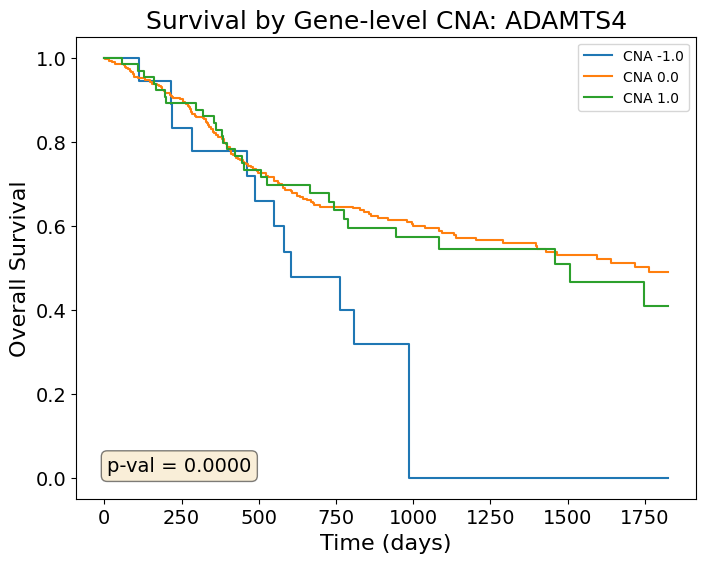

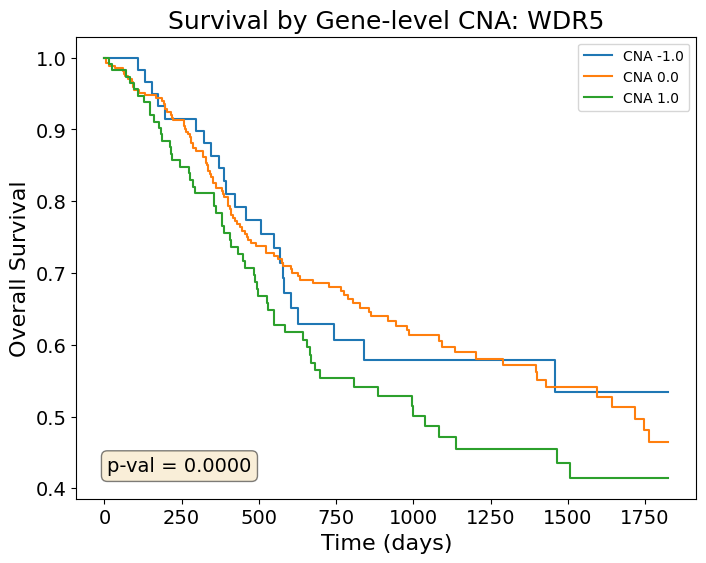

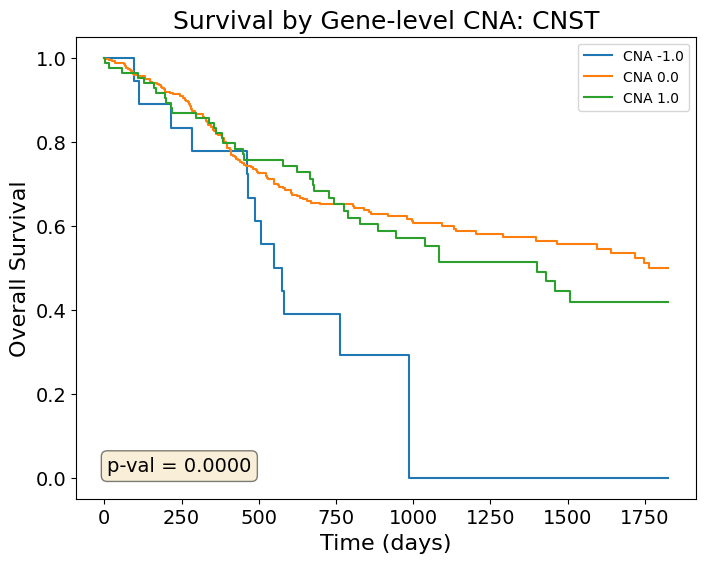

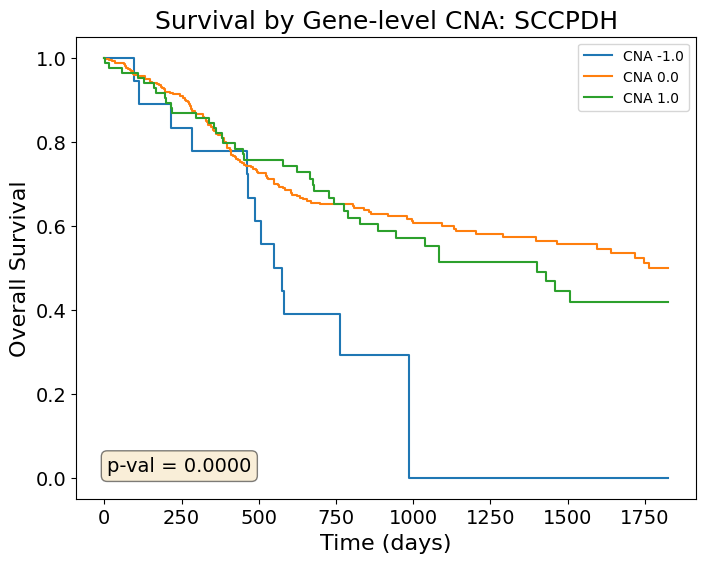

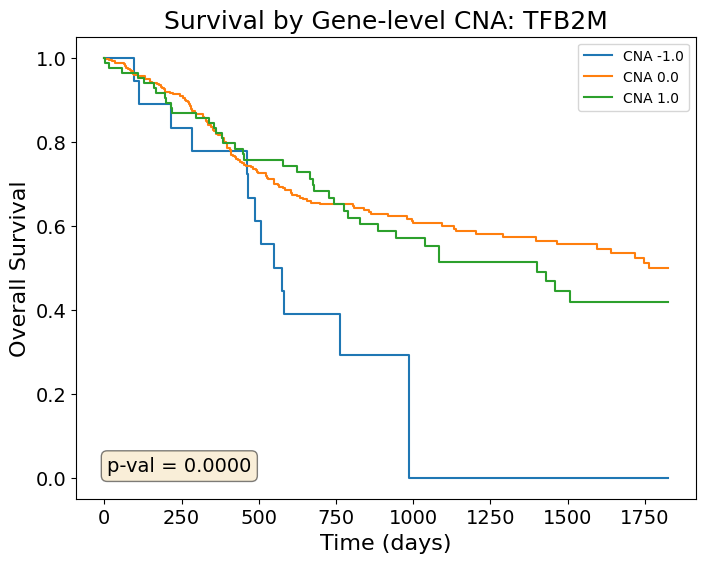

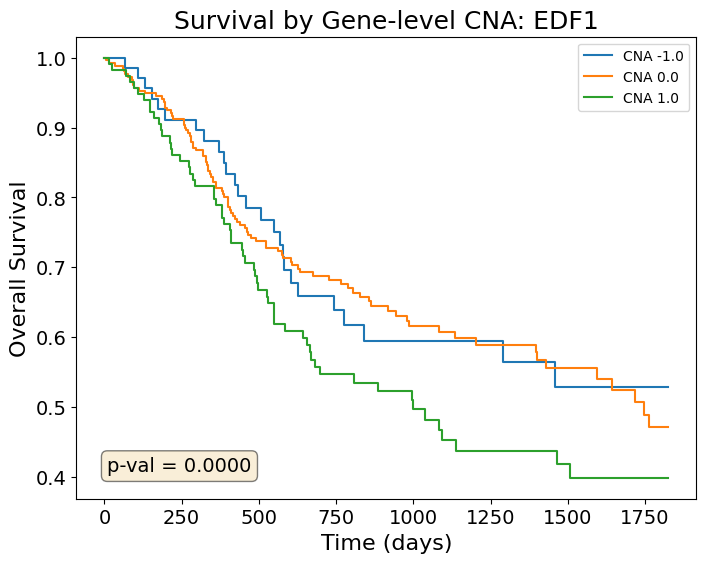

In [107]:
for gene in km_df[km_df["q"] < 0.05]["gene"]:
    plot_km_with_cutoff(df, gene, cutoff_days=cutoff)